### 为celeba人脸数据集额外搭建了一个模型，他在处理属性标签时与MNIST等有所不同
### 以下为模型及其训练源码

In [9]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import numpy as np
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/celeba/list_attr_celeba.csv')
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [3]:
class CelebADataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.attr_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.attr_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.attr_frame.iloc[idx, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        attributes = self.attr_frame.iloc[idx, 1:].to_numpy()
        attributes = torch.from_numpy(attributes.astype('float')).float()

        return image, attributes

In [4]:
class ConditionalConvVAE(nn.Module):
    """
    条件全卷积VAE变分自动编码器
    """
    NAME = 'ConditionalConvVAE'
    
    def __init__(self, potential_dim, channels, num_attributes=40):
        super(ConditionalConvVAE, self).__init__()
        self.potential_dim = potential_dim
        self.channels = channels
        
        # 对类别标签进行编码的线性层
        self.attr_embedding = nn.Linear(num_attributes, num_attributes)
        
        output_shape = (128, 6, 7)
        
        output_dim = output_shape[0] * output_shape[1] * output_shape[2]
        # image_size = (178, 218)
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(channels + num_attributes, 64, kernel_size=3, stride=2, padding=1),  # 89
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 45
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 23
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 12
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 6
            nn.Flatten(),
        )
        
        
        self.enc_mu = nn.Linear(output_dim, potential_dim)     # 均值
        self.enc_log_var = nn.Linear(output_dim, potential_dim) # 对数方差
        # 解码器
        self.decoder_fc = nn.Linear(potential_dim + num_attributes, output_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, output_shape),  # 6
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 12
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),  # 23
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),  # 45
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),  # 89
            nn.ConvTranspose2d(64, channels, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.AdaptiveAvgPool2d((178, 218)),
            nn.Sigmoid()
        )

    def encode(self, x, attributes):
        # 将标签嵌入到与图像相同的维度
        # print(x.shape)  # torch.Size([128, 3, 178, 218])
        embedded_attrs = self.attr_embedding(attributes).unsqueeze(2).unsqueeze(3)
        embedded_attrs = embedded_attrs.expand(embedded_attrs.size(0), embedded_attrs.size(1), x.size(2), x.size(3))
        
        # 将标签和图像连接起来
        x = torch.cat((x, embedded_attrs), dim=1)
        
        # 传入编码器
        x = self.encoder(x)
        # print(x.shape)
        mu = self.enc_mu(x)
        log_var = self.enc_log_var(x)
        
        # 重参数化
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z, mu, log_var

    def decode(self, z, labels):
        # 将标签嵌入并与潜在向量连接起来
        labels = self.attr_embedding(labels)
        z = torch.cat((z, labels), dim=1)
        
        # 传入解码器
        x = self.decoder_fc(z)
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        z, mu, log_var = self.encode(x, labels)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mu, log_var


# 定义损失函数
def vae_loss(recon_x, x, mu, log_var):
    # print(recon_x.shape, x.shape)
    batch_size = recon_x.size(0)
    # 重构损失：通常使用二元交叉熵（BCE）损失
    MSE = nn.functional.mse_loss(recon_x.view(batch_size, -1), x.view(batch_size, -1), reduction='sum')
    # KL 散度损失：用于度量学到的潜在分布与标准正态分布之间的差异
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = MSE + KLD
    return loss, np.array([loss.item(), MSE.item(), KLD.item()])


In [5]:
# 查看可用的训练设备
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
class DatasetType(Enum):
    cifar10 = 'cifar10'
    mnist = 'mnist'
    fashion_mnist = 'fashion_mnist'
    svhn = 'svhn'
    celeba = 'celeba'
    

In [7]:
# 训练配置
batch_size = 128
epochs = 50
potential_dim = 64
dataset_type = DatasetType.celeba  # 在这里设置你的数据集

In [8]:
MODEL_PATH = f'models/cvae_{dataset_type.value}.pth'
HISTORY_PATH = f'history/cvae_{dataset_type.value}_history.npy'
CHANNELS = 1 if dataset_type in [DatasetType.mnist, DatasetType.fashion_mnist] else 3

os.makedirs('history', exist_ok=True)

# 模型和优化器
vae = ConditionalConvVAE(potential_dim=potential_dim, channels=CHANNELS)
vae.to(device)

running_losses = []
if os.path.exists(MODEL_PATH):
    try:
        vae.load_state_dict(torch.load(MODEL_PATH))
        running_losses = list(np.load(HISTORY_PATH)) if os.path.exists(HISTORY_PATH) else []
    except RuntimeError:
        pass

In [ ]:
images_path = 'data/celeba/img_align_celeba/img_align_celeba'
image_size = (178, 218)

# Usage
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

train_dataset = CelebADataset(csv_file='data/celeba/list_attr_celeba.csv',
                               img_dir='data/celeba/img_align_celeba/img_align_celeba',
                               transform=transform)

optimizer = optim.Adam(vae.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

p_bar = tqdm(range(epochs))
for epoch in p_bar:
    running_loss = np.array([0., 0., 0.])
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data, labels)
        loss, losses = vae_loss(recon_batch, data, mu, log_var)
        loss.backward()

        optimizer.step()
        running_loss += 1 / (batch_idx + 1) * (losses - running_loss)
        p_bar.set_postfix(progress=f'{(batch_idx + 1) / len(train_loader) * 100:.2f}%',
                          totalLoss=f'{running_loss[0]:.3f}', MSELoss=f'{running_loss[1]:.3f}',
                          KLDLoss=f'{running_loss[2]:.3f}')

    running_losses.append(running_loss)
    np.save(HISTORY_PATH, np.array(running_losses))
    torch.save(vae.state_dict(), MODEL_PATH)


  0%|          | 0/50 [00:39<?, ?it/s, KLDLoss=8177.341, MSELoss=932155.725, progress=7.90%, totalLoss=940333.067]  

### 绘制损失曲线

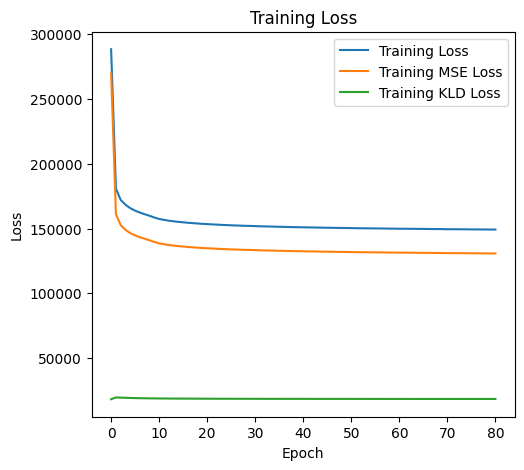

In [10]:
plt.figure(figsize=(12, 5))
total_loss, bce_loss, kld_loss = np.array(running_losses).T
# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(total_loss, label='Training Loss')
plt.plot(bce_loss, label='Training MSE Loss')
plt.plot(kld_loss, label='Training KLD Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [16]:
def generate(model, labels, device='cuda'):
    with torch.no_grad():
        num_samples = len(labels)
        z = torch.randn(num_samples, model.potential_dim).to(device)
        labels = torch.FloatTensor(np.array(labels)).to(device)
        # 通过解码器生成图像
        generated_images = model.decode(z, labels)
    return generated_images

def plot(images):
    plt.figure(figsize=(8, 8))
    channels = images.size(1)
    for i, image in enumerate(images):
        plt.subplot(8, 8, i+1)
        img = image.squeeze().cpu().numpy()
        if channels == 3:
            img = np.transpose(img, (2, 1, 0))
            
        plt.imshow(img, cmap='gray' if channels == 1 else None)
        plt.axis('off')
    plt.show()

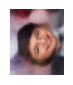

In [47]:
labels = [[1.] * 40]
images = generate(vae, labels, device)
plot(images)